In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import numpy as np

from mcopt.pipeline import Pipeline
from mcopt import MorseGraph, ot

/workspaces/MCOpt/mcopt/pipeline/pipeline.py:34: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
pipeline = Pipeline('../pipeline.config.json')

red_sea = pipeline.graph('red_sea')

> Generating red_sea graph
  config unchanged, loading graph
  loaded 10 frames


In [4]:
src = red_sea.frames[0]

dests = red_sea.frames.copy()
dests.pop(0)

In [5]:
cmap = 'cool'

# Initial Graphs

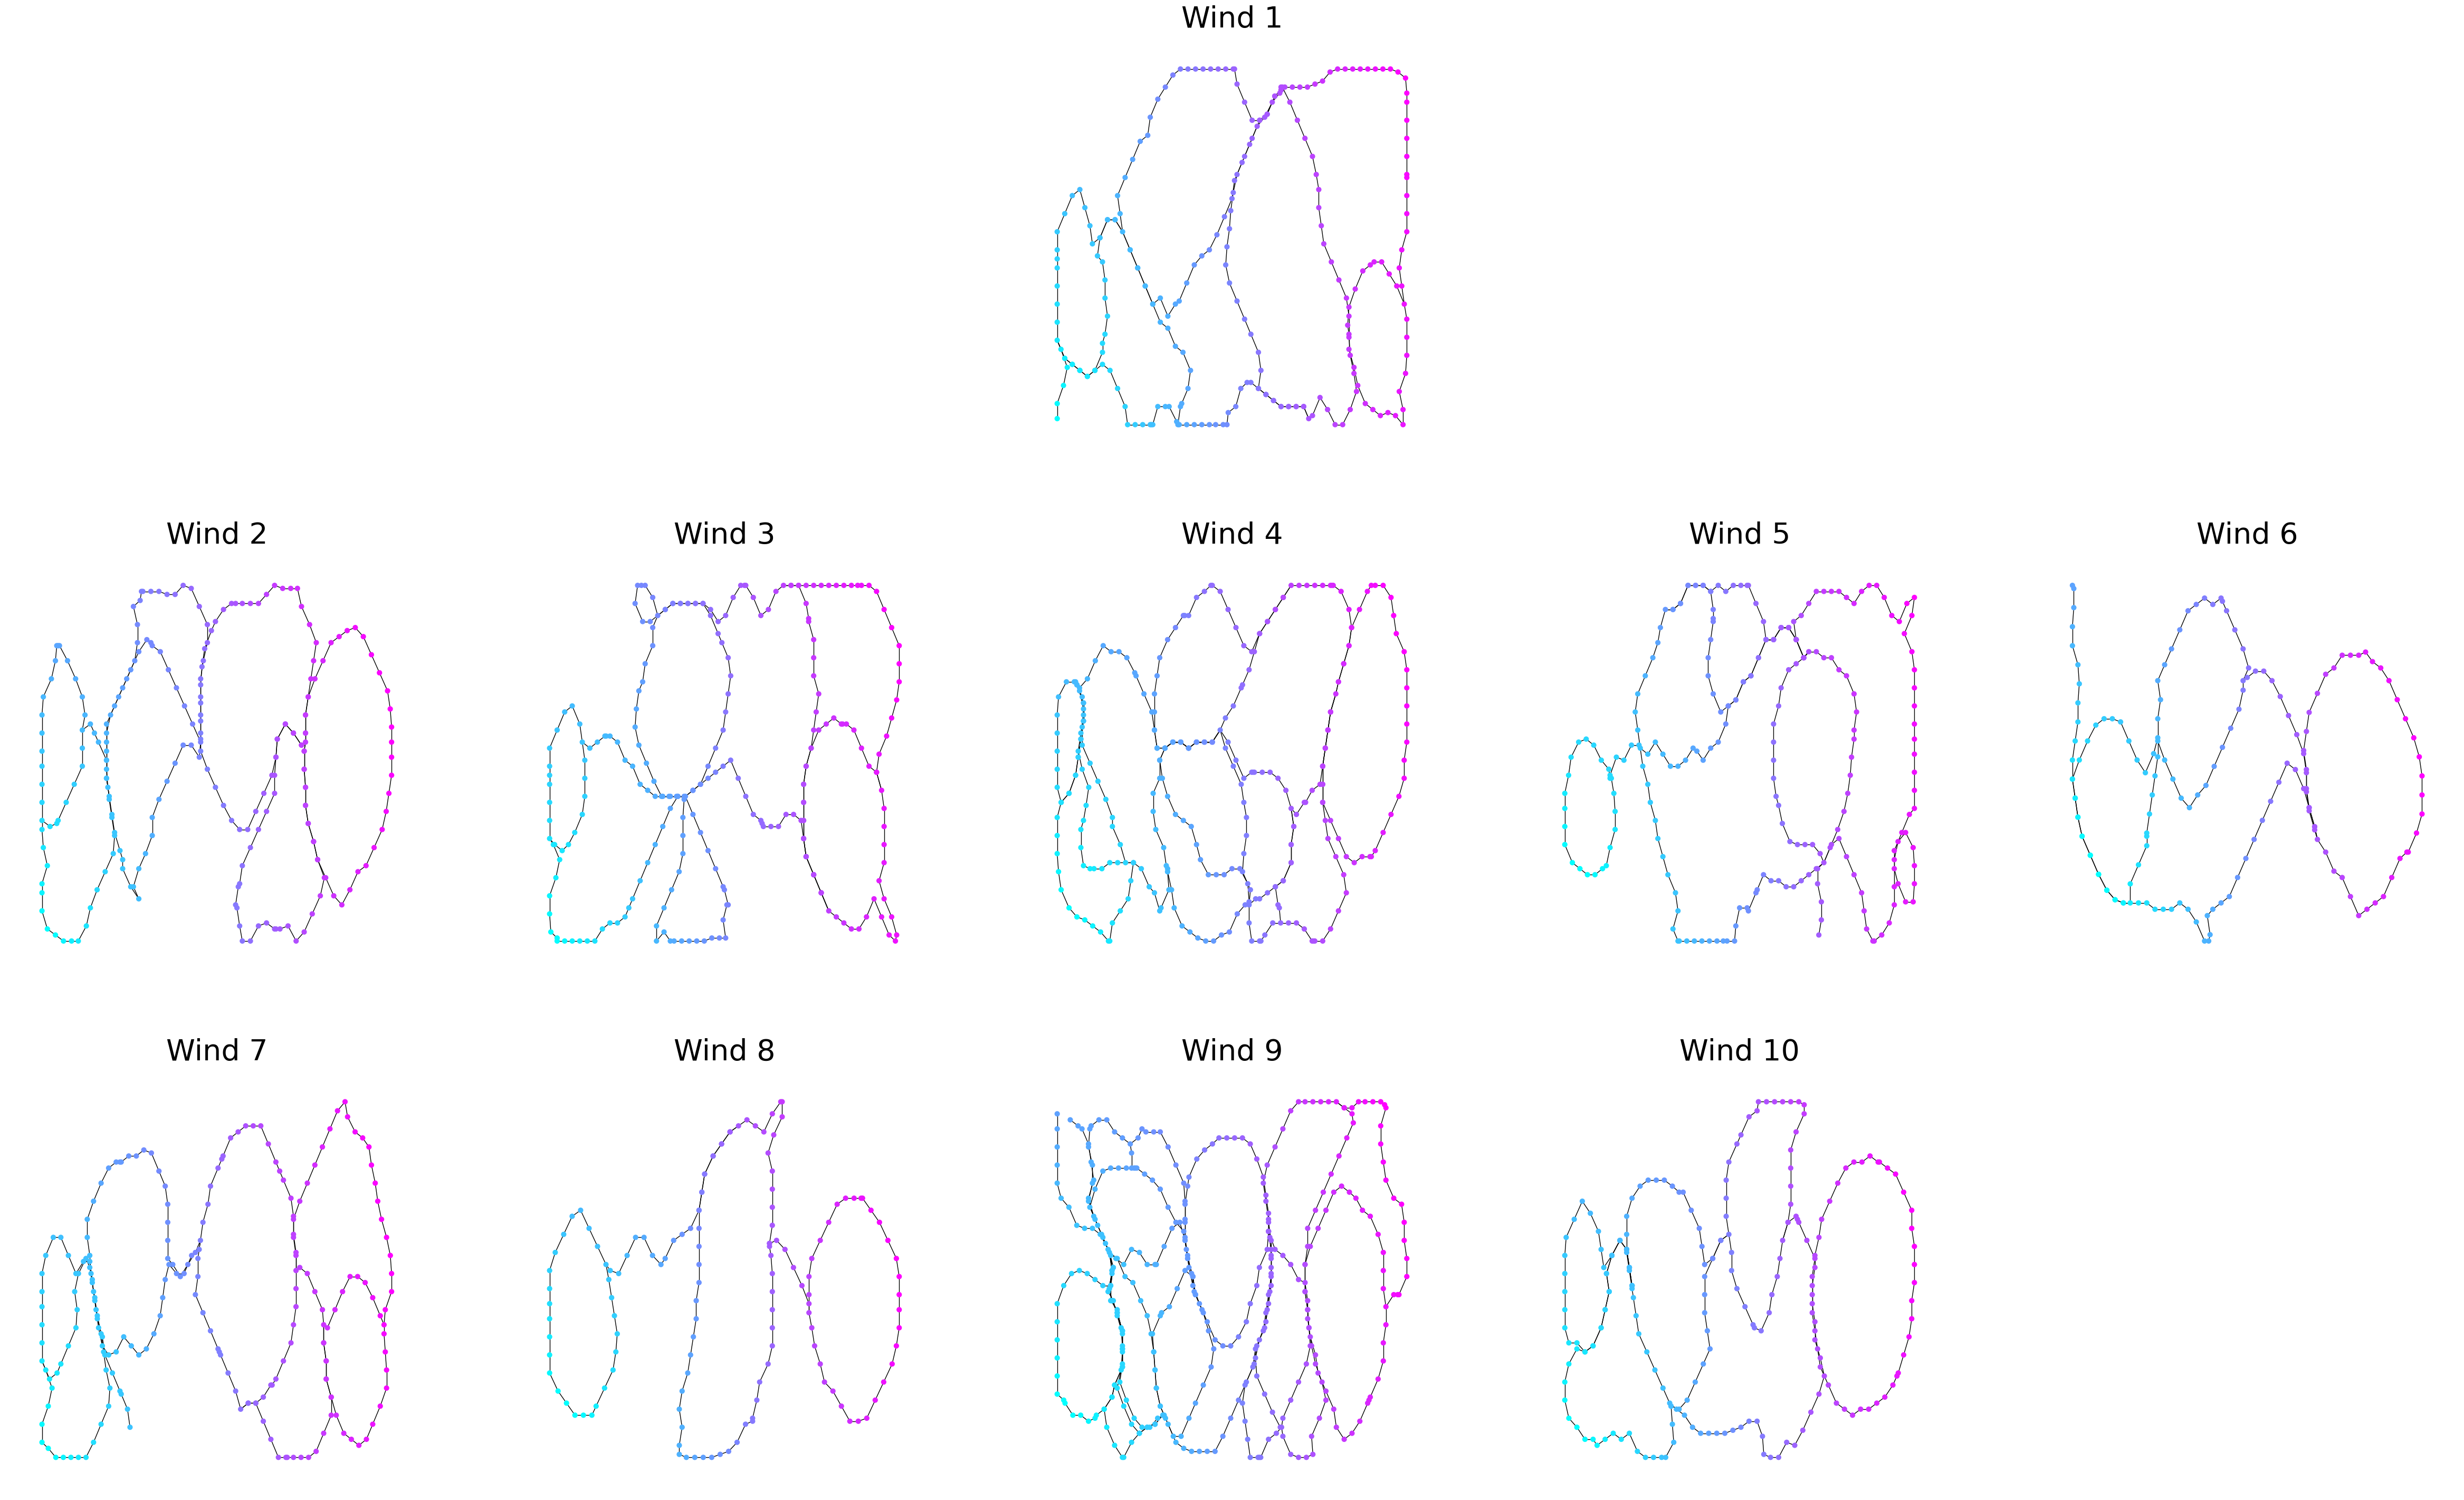

In [6]:
w, h = 5, 3
fig, axes = plt.subplots(h, w, figsize=(w * 12, h * 12))

for ax in axes.ravel():
  ax.set_axis_off()
  
src.draw(
  ax = axes[0, w//2],
  cmap=cmap
)
axes[0, w//2].set_title(f'Wind 1', fontsize=40)

for (i, dest), ax in zip(dests.items(), axes.ravel()[w:]):
  dest.draw(
    ax=ax,
    cmap=cmap
  )
  ax.set_title(f'Wind {i + 1}', fontsize=40)

# GW Transport

In [7]:
dist = 'geo'
hist = 'degree'

random_state = np.random.default_rng(42)
num_random_iter = 10

In [8]:
gw_couplings = {}

src_net = src.to_mpn(hist=hist, dist=dist)

for (i, dest) in dests.items():
  dest_net = dest.to_mpn(hist=hist, dist=dist)
  
  min_dist = float('inf')
  min_coupling = None
  
  for _ in range(num_random_iter):
    coupling, d = ot.GW(src_net, dest_net, random_G0=True, random_state=random_state)
    
    if d < min_dist:
      min_dist = d
      min_coupling = coupling
      
  gw_couplings[i] = min_coupling

Text(0.5, 0.98, 'GW Transport')

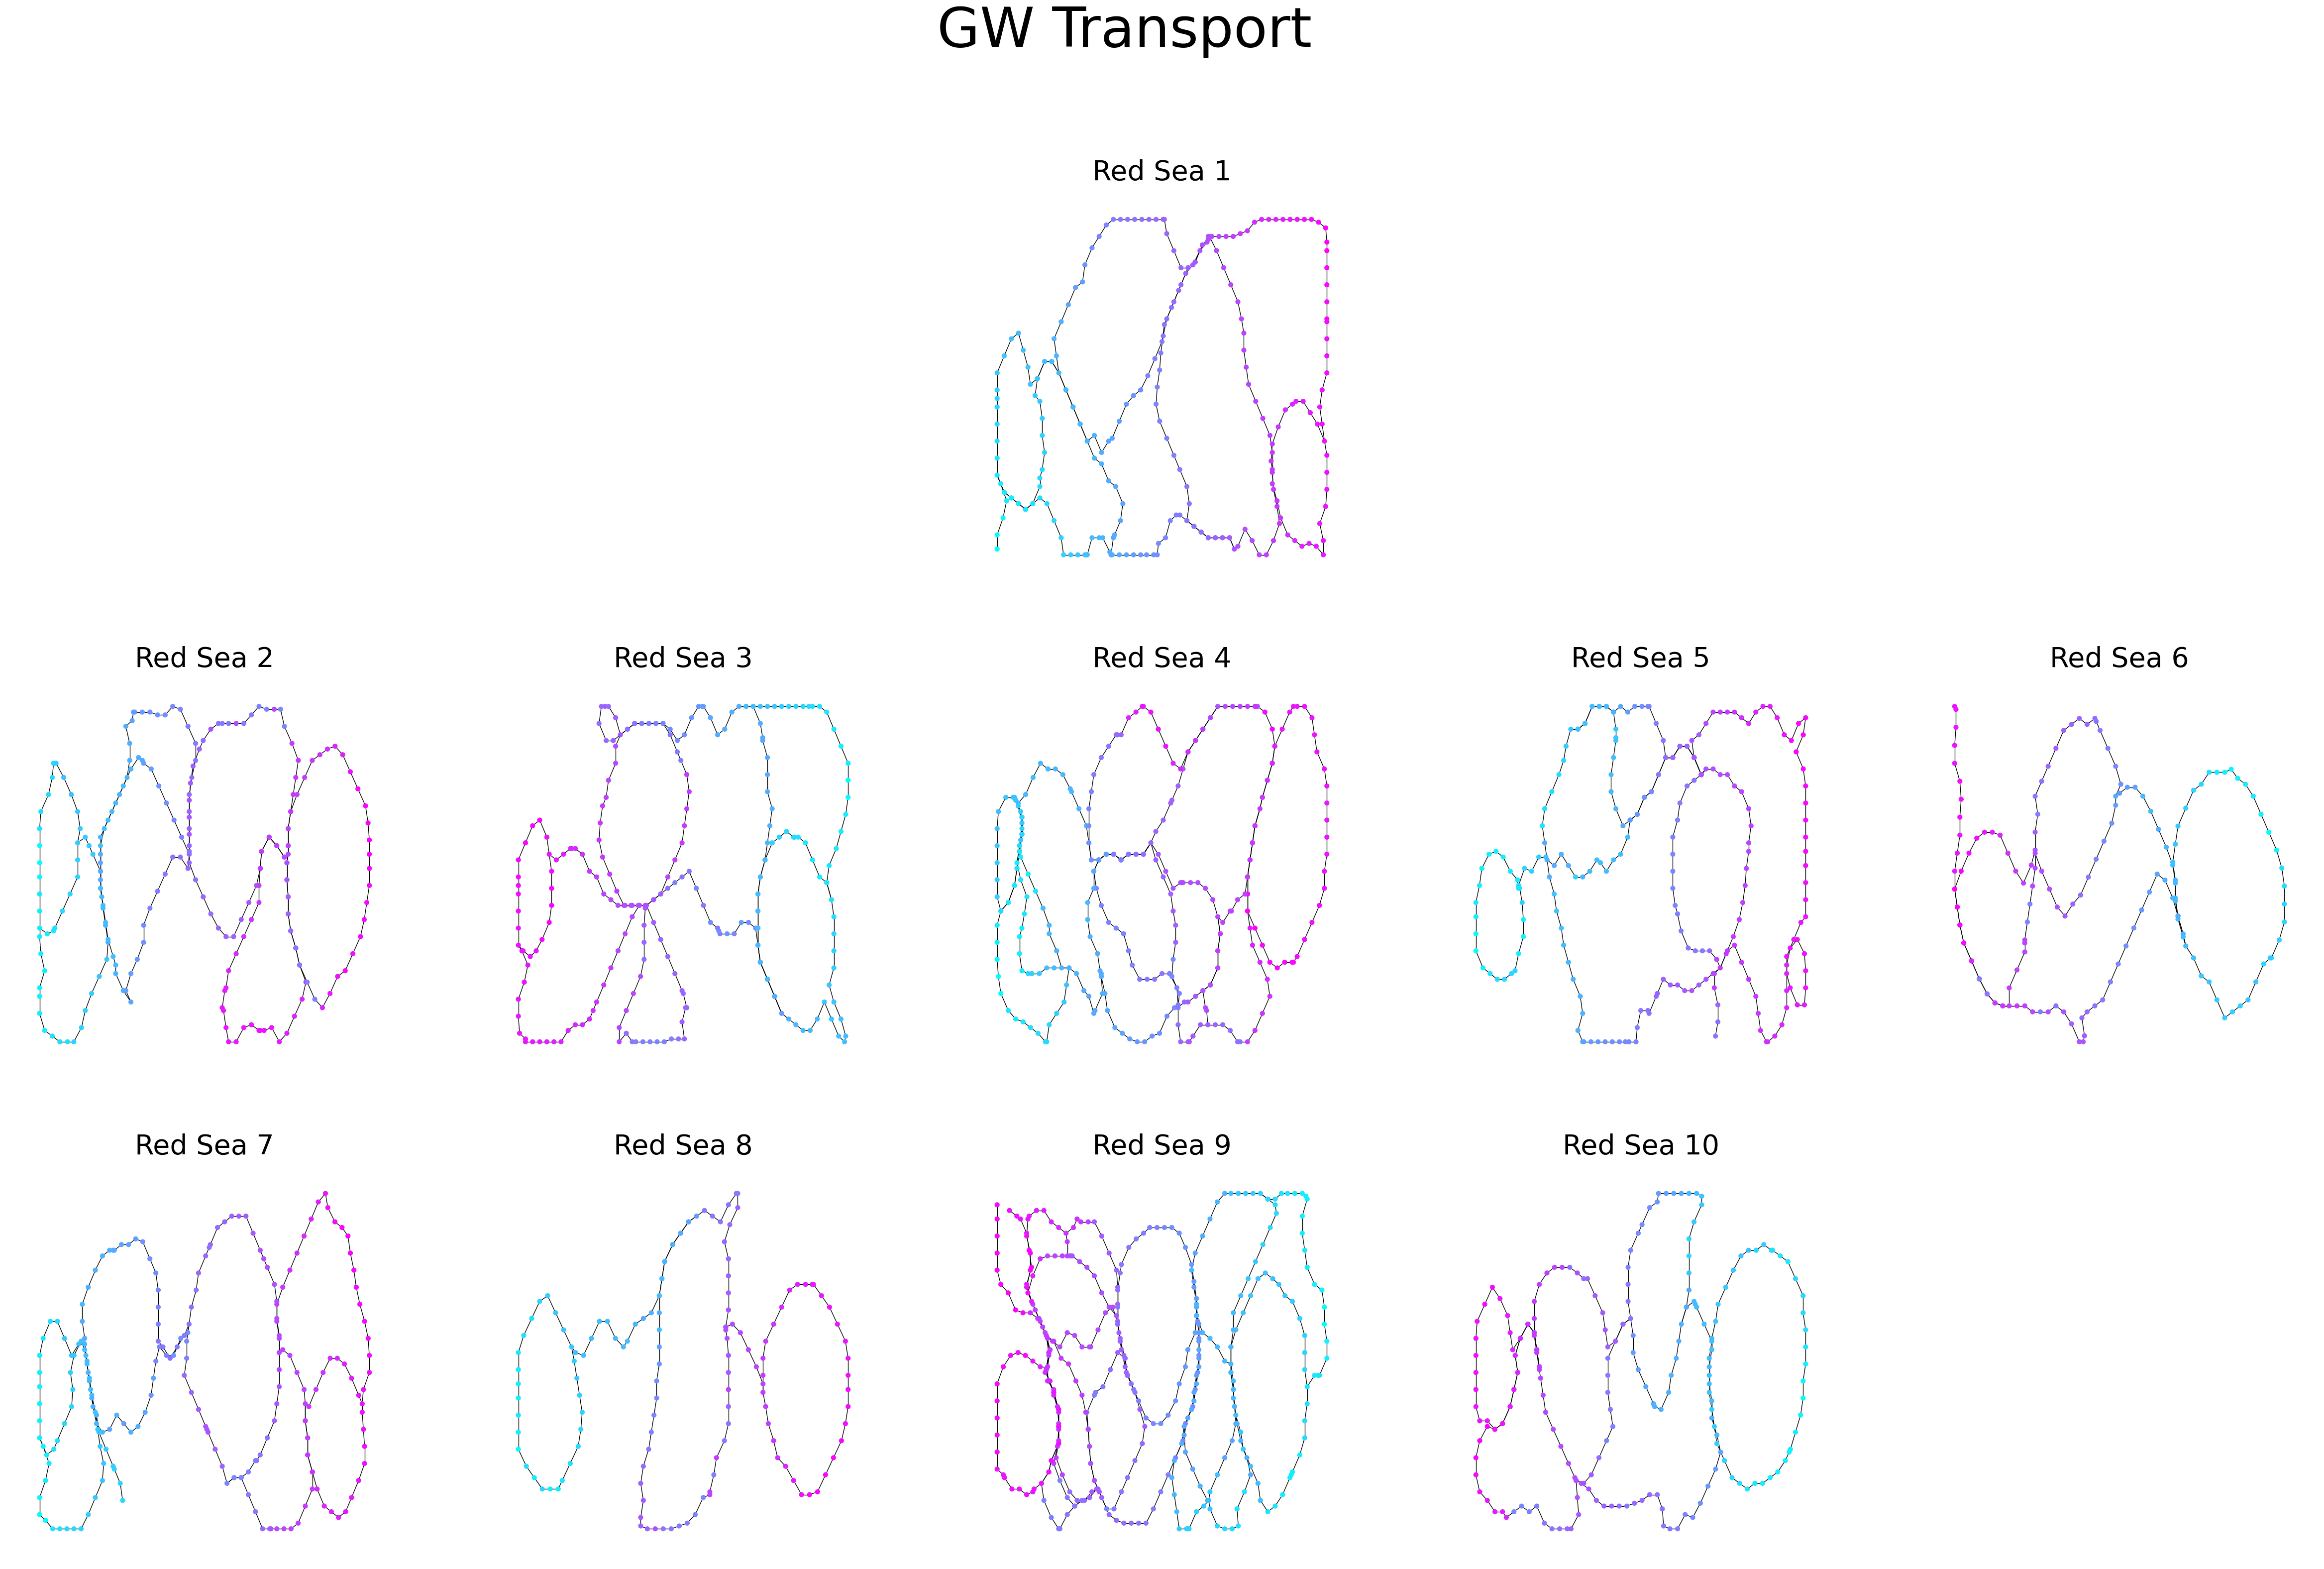

In [16]:
w, h = 5, 3
fig, axes = plt.subplots(h, w, figsize=(w * 12, h * 12))

for ax in axes.ravel():
  ax.set_axis_off()

src_node_color = src.node_color_by_position()
src.draw(
  ax = axes[0, w//2],
  cmap=cmap,
  node_color = src_node_color,
)
axes[0, w//2].set_title(f'Red Sea 1', fontsize=40)

for (i, dest), ax in zip(dests.items(), axes.ravel()[w:]):
  dest.draw(
    ax=ax,
    cmap=cmap,
    node_color = dest.node_color_by_coupling(src_node_color, gw_couplings[i])
  )
  ax.set_title(f'Red Sea {i + 1}', fontsize=40)
  
fig.suptitle('GW Transport', fontsize=80)

# Fused GW Transport

In [10]:
alpha = 0.5

In [11]:
fgw_couplings = {}

src_net = src.to_mpn(hist=hist, dist=dist)

for (i, dest) in dests.items():
  M = MorseGraph.attribute_cost_matrix(src, dest)
  
  dest_net = dest.to_mpn(hist=hist, dist=dist)
  
  coupling, _ = ot.fGW(src_net, dest_net, M, alpha=alpha, random_G0=True, random_state=random_state)
  
  fgw_couplings[i] = coupling

Text(0.5, 0.98, 'fGW Transport')

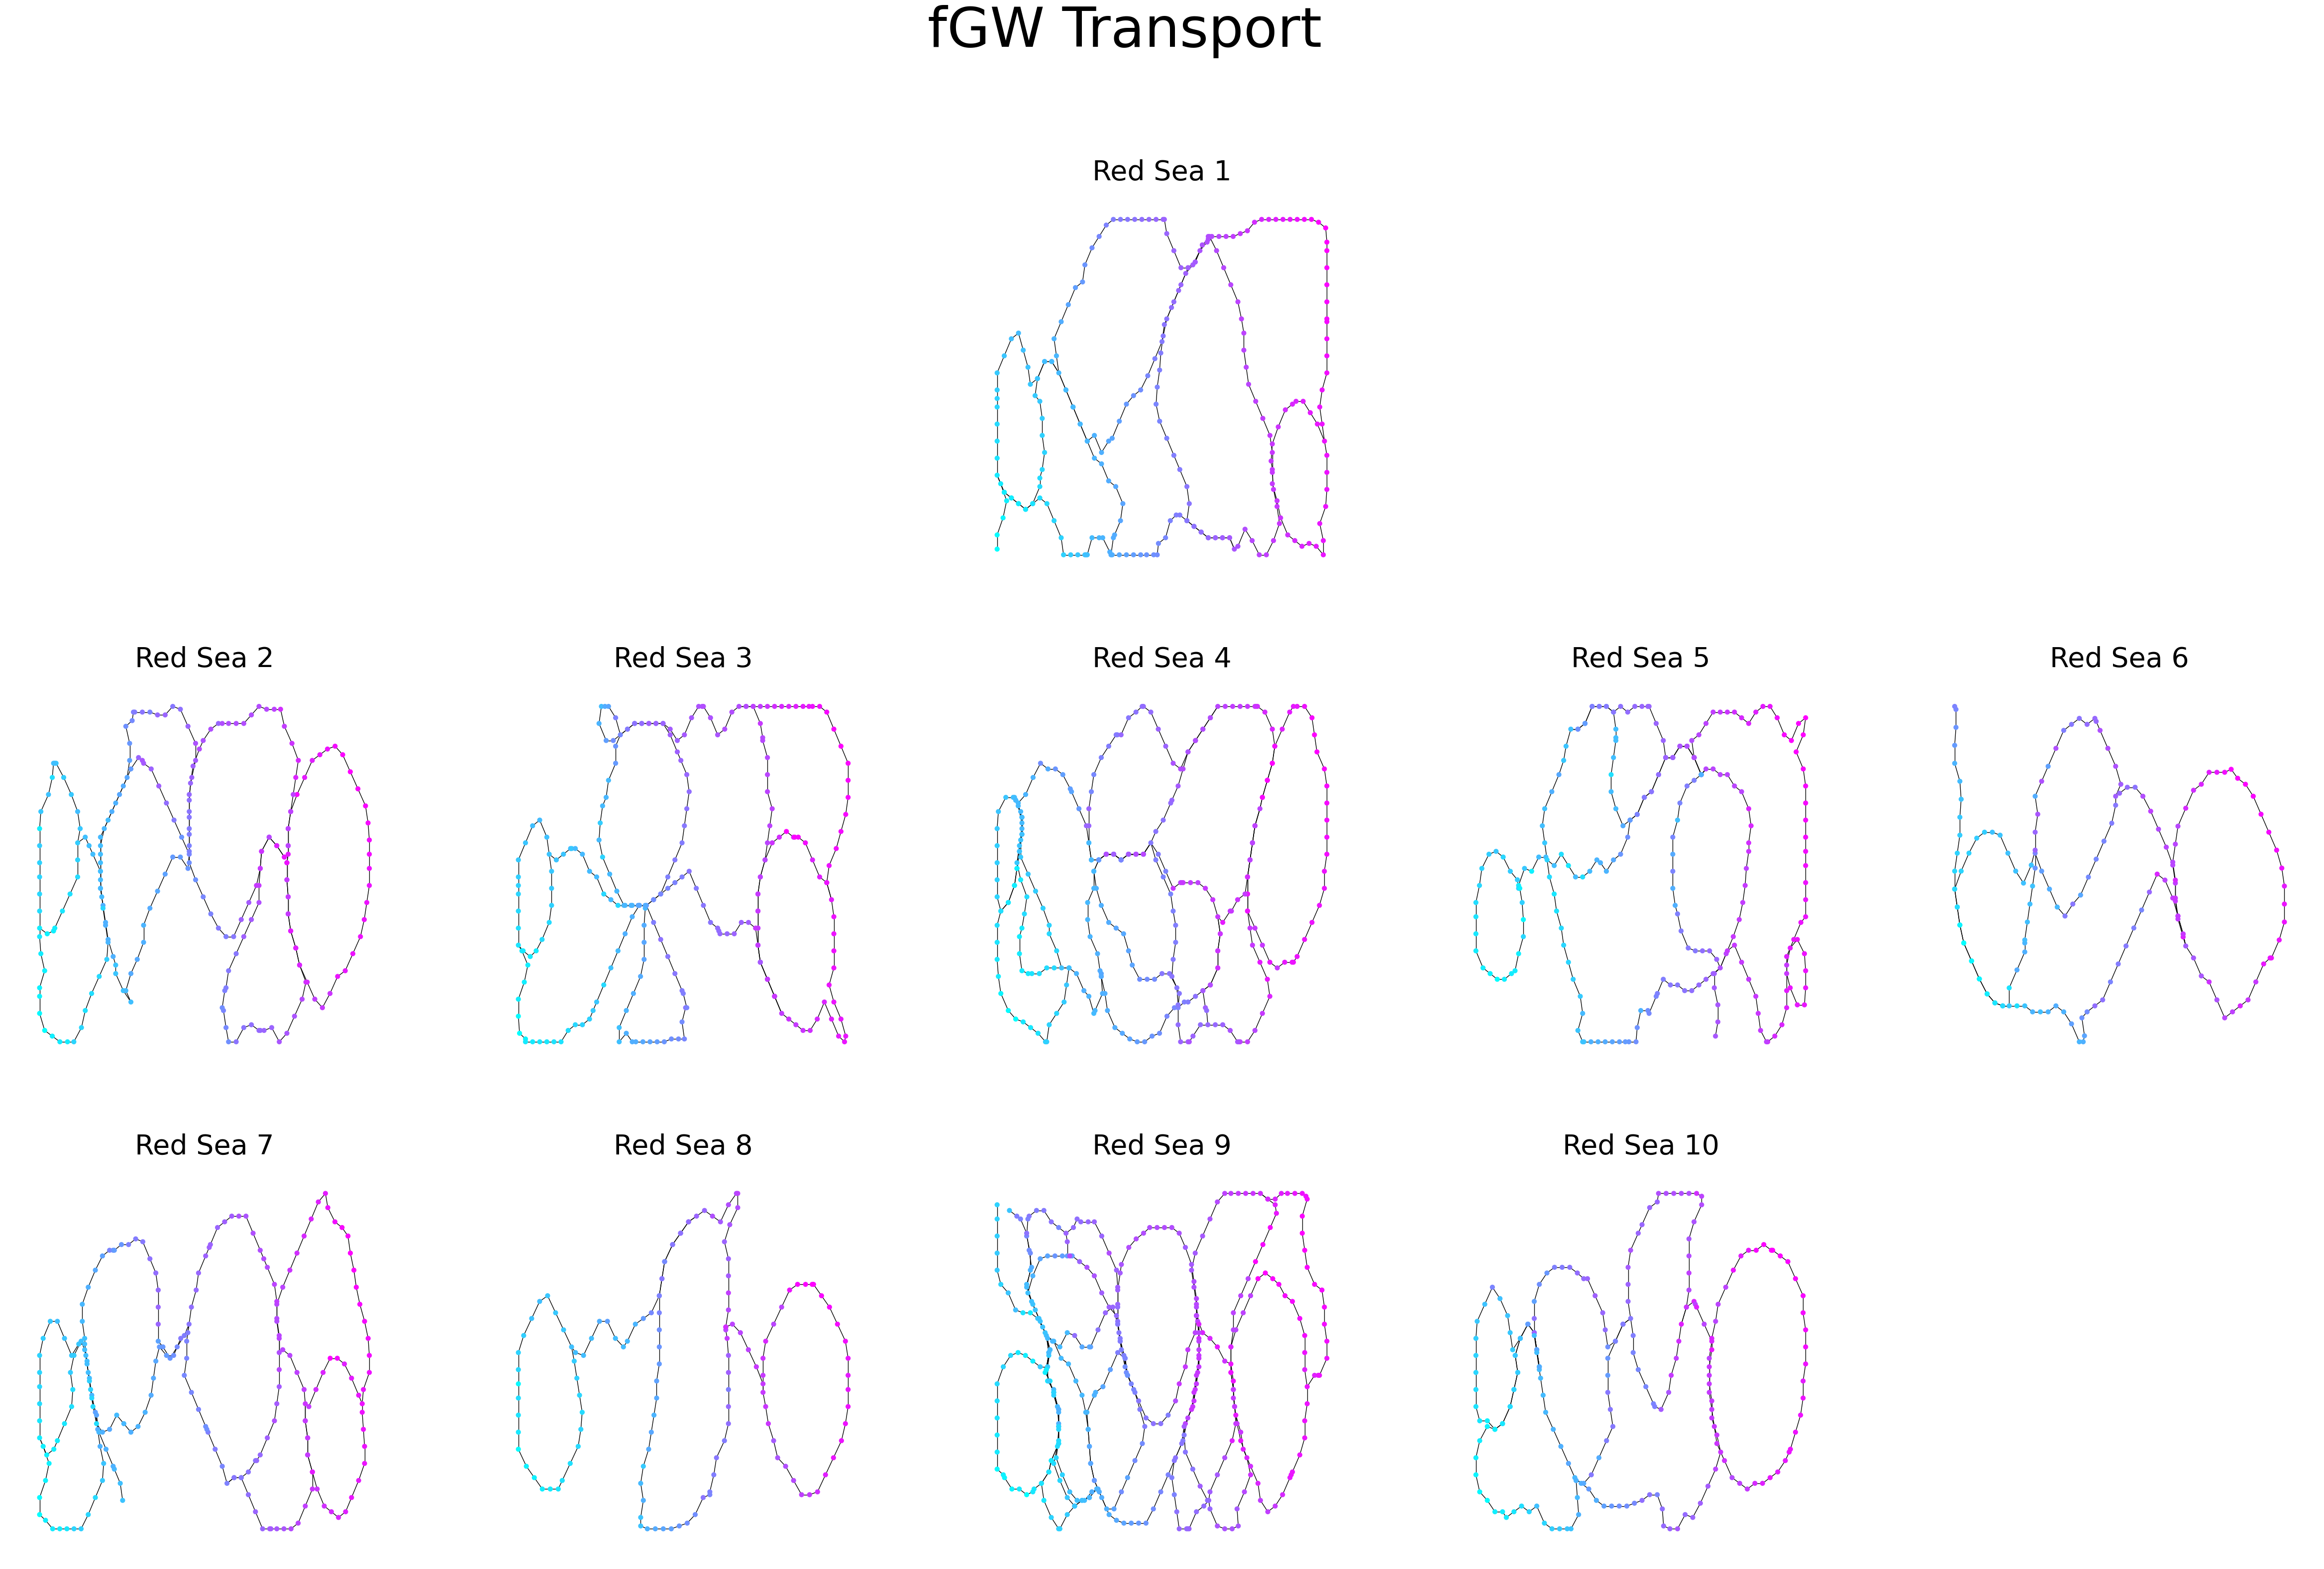

In [15]:
w, h = 5, 3
fig, axes = plt.subplots(h, w, figsize=(w * 12, h * 12))

for ax in axes.ravel():
  ax.set_axis_off()

src_node_color = src.node_color_by_position()
src.draw(
  ax = axes[0, w//2],
  cmap=cmap,
  node_color = src_node_color,
)
axes[0, w//2].set_title(f'Red Sea 1', fontsize=40)

for (i, dest), ax in zip(dests.items(), axes.ravel()[w:]):
  dest.draw(
    ax=ax,
    cmap=cmap,
    node_color = dest.node_color_by_coupling(src_node_color, fgw_couplings[i])
  )
  ax.set_title(f'Red Sea {i + 1}', fontsize=40)
  
fig.suptitle('fGW Transport', fontsize=80)

# Tune m for partial fused

In [17]:
m_start = 0.85
num_ms = 20

m_step = (1 - m_start) / num_ms
ms = np.array([m_start + m_step * i for i in range(num_ms + 1)])
ms

array([0.85  , 0.8575, 0.865 , 0.8725, 0.88  , 0.8875, 0.895 , 0.9025,
       0.91  , 0.9175, 0.925 , 0.9325, 0.94  , 0.9475, 0.955 , 0.9625,
       0.97  , 0.9775, 0.985 , 0.9925, 1.    ])

In [18]:
results = np.zeros(shape = (len(ms), len(dests)))

src_net = src.to_mpn(hist=hist, dist=dist)

for res_i, dest in enumerate(dests.values()):
  M = MorseGraph.attribute_cost_matrix(src, dest)
  dest_net = dest.to_mpn(hist=hist, dist=dist)
  
  for m_i, m in enumerate(ms):
    min_dist = float('inf')
    min_coupling = None
    
    for _ in range(num_random_iter):
      if np.isclose(m, 1):
        coupling, d = ot.fGW(src_net, dest_net, M, alpha=alpha, random_G0=True, random_state=random_state)
      else:
        coupling, d = ot.fpGW(src_net, dest_net, m, M, alpha=alpha, random_G0=True, random_state=random_state)
        
      if d < min_dist:
        min_dist = d
        min_coupling = coupling
        
    max_match_dist = 0
    
    for dest_n in dest.nodes:
      dest_i = min_coupling.dest_rev_map[dest_n]
      src_i = min_coupling[:, dest_i].argmax()
      
      if np.isclose(min_coupling[src_i, dest_i], 0):
        continue
      
      src_n = min_coupling.src_map[src_i]
      
      dest_pos = dest.nodes(data='pos2')[dest_n]
      src_pos = src.nodes(data='pos2')[src_n]
      
      match_dist = np.linalg.norm(dest_pos - src_pos)
      
      if match_dist > max_match_dist:
        max_match_dist = match_dist
    
    results[m_i, res_i] = max_match_dist

Text(0.5, 0.98, 'Red Sea m tuning holistic')

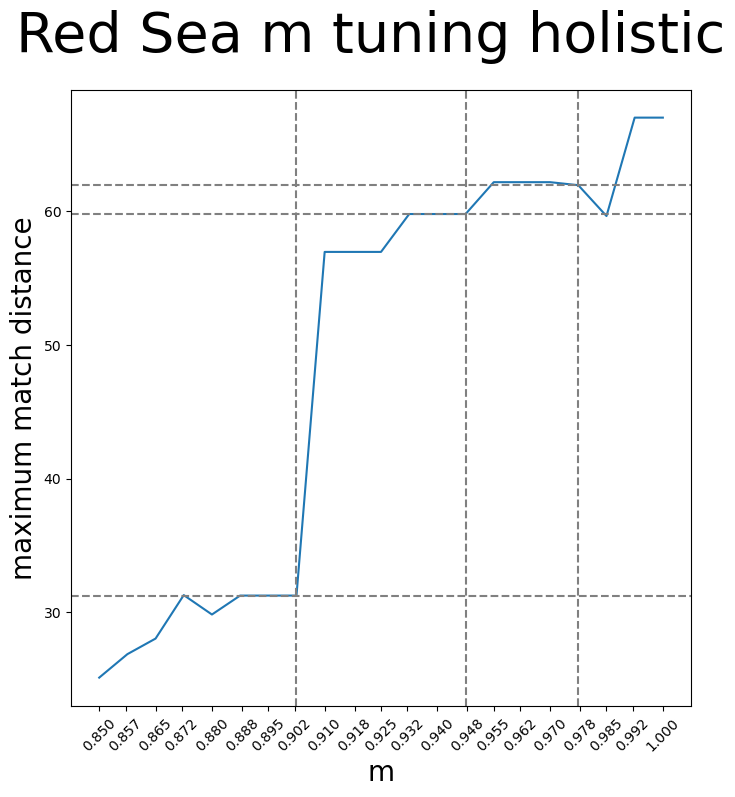

In [23]:
fig, ax = plt.subplots()

x = ms
y = results.max(axis=1)

ax.plot(x, y)
ax.set_xticks(np.round(ms, decimals=3))
ax.tick_params(axis='x', labelrotation=45, labelright=True)

ax.set_xlabel('m', fontsize=20)
ax.set_ylabel('maximum match distance', fontsize=20)

ax.axvline(x = x[7], color='grey', linestyle='--')
ax.axhline(y = y[7], color='grey', linestyle='--')

ax.axvline(x = x[13], color='grey', linestyle='--')
ax.axhline(y = y[13], color='grey', linestyle='--')

ax.axvline(x = x[17], color='grey', linestyle='--')
ax.axhline(y = y[17], color='grey', linestyle='--')

fig.suptitle('Red Sea m tuning holistic', fontsize=40)

Text(0.5, 0.98, 'Red Sea m tuning individual')

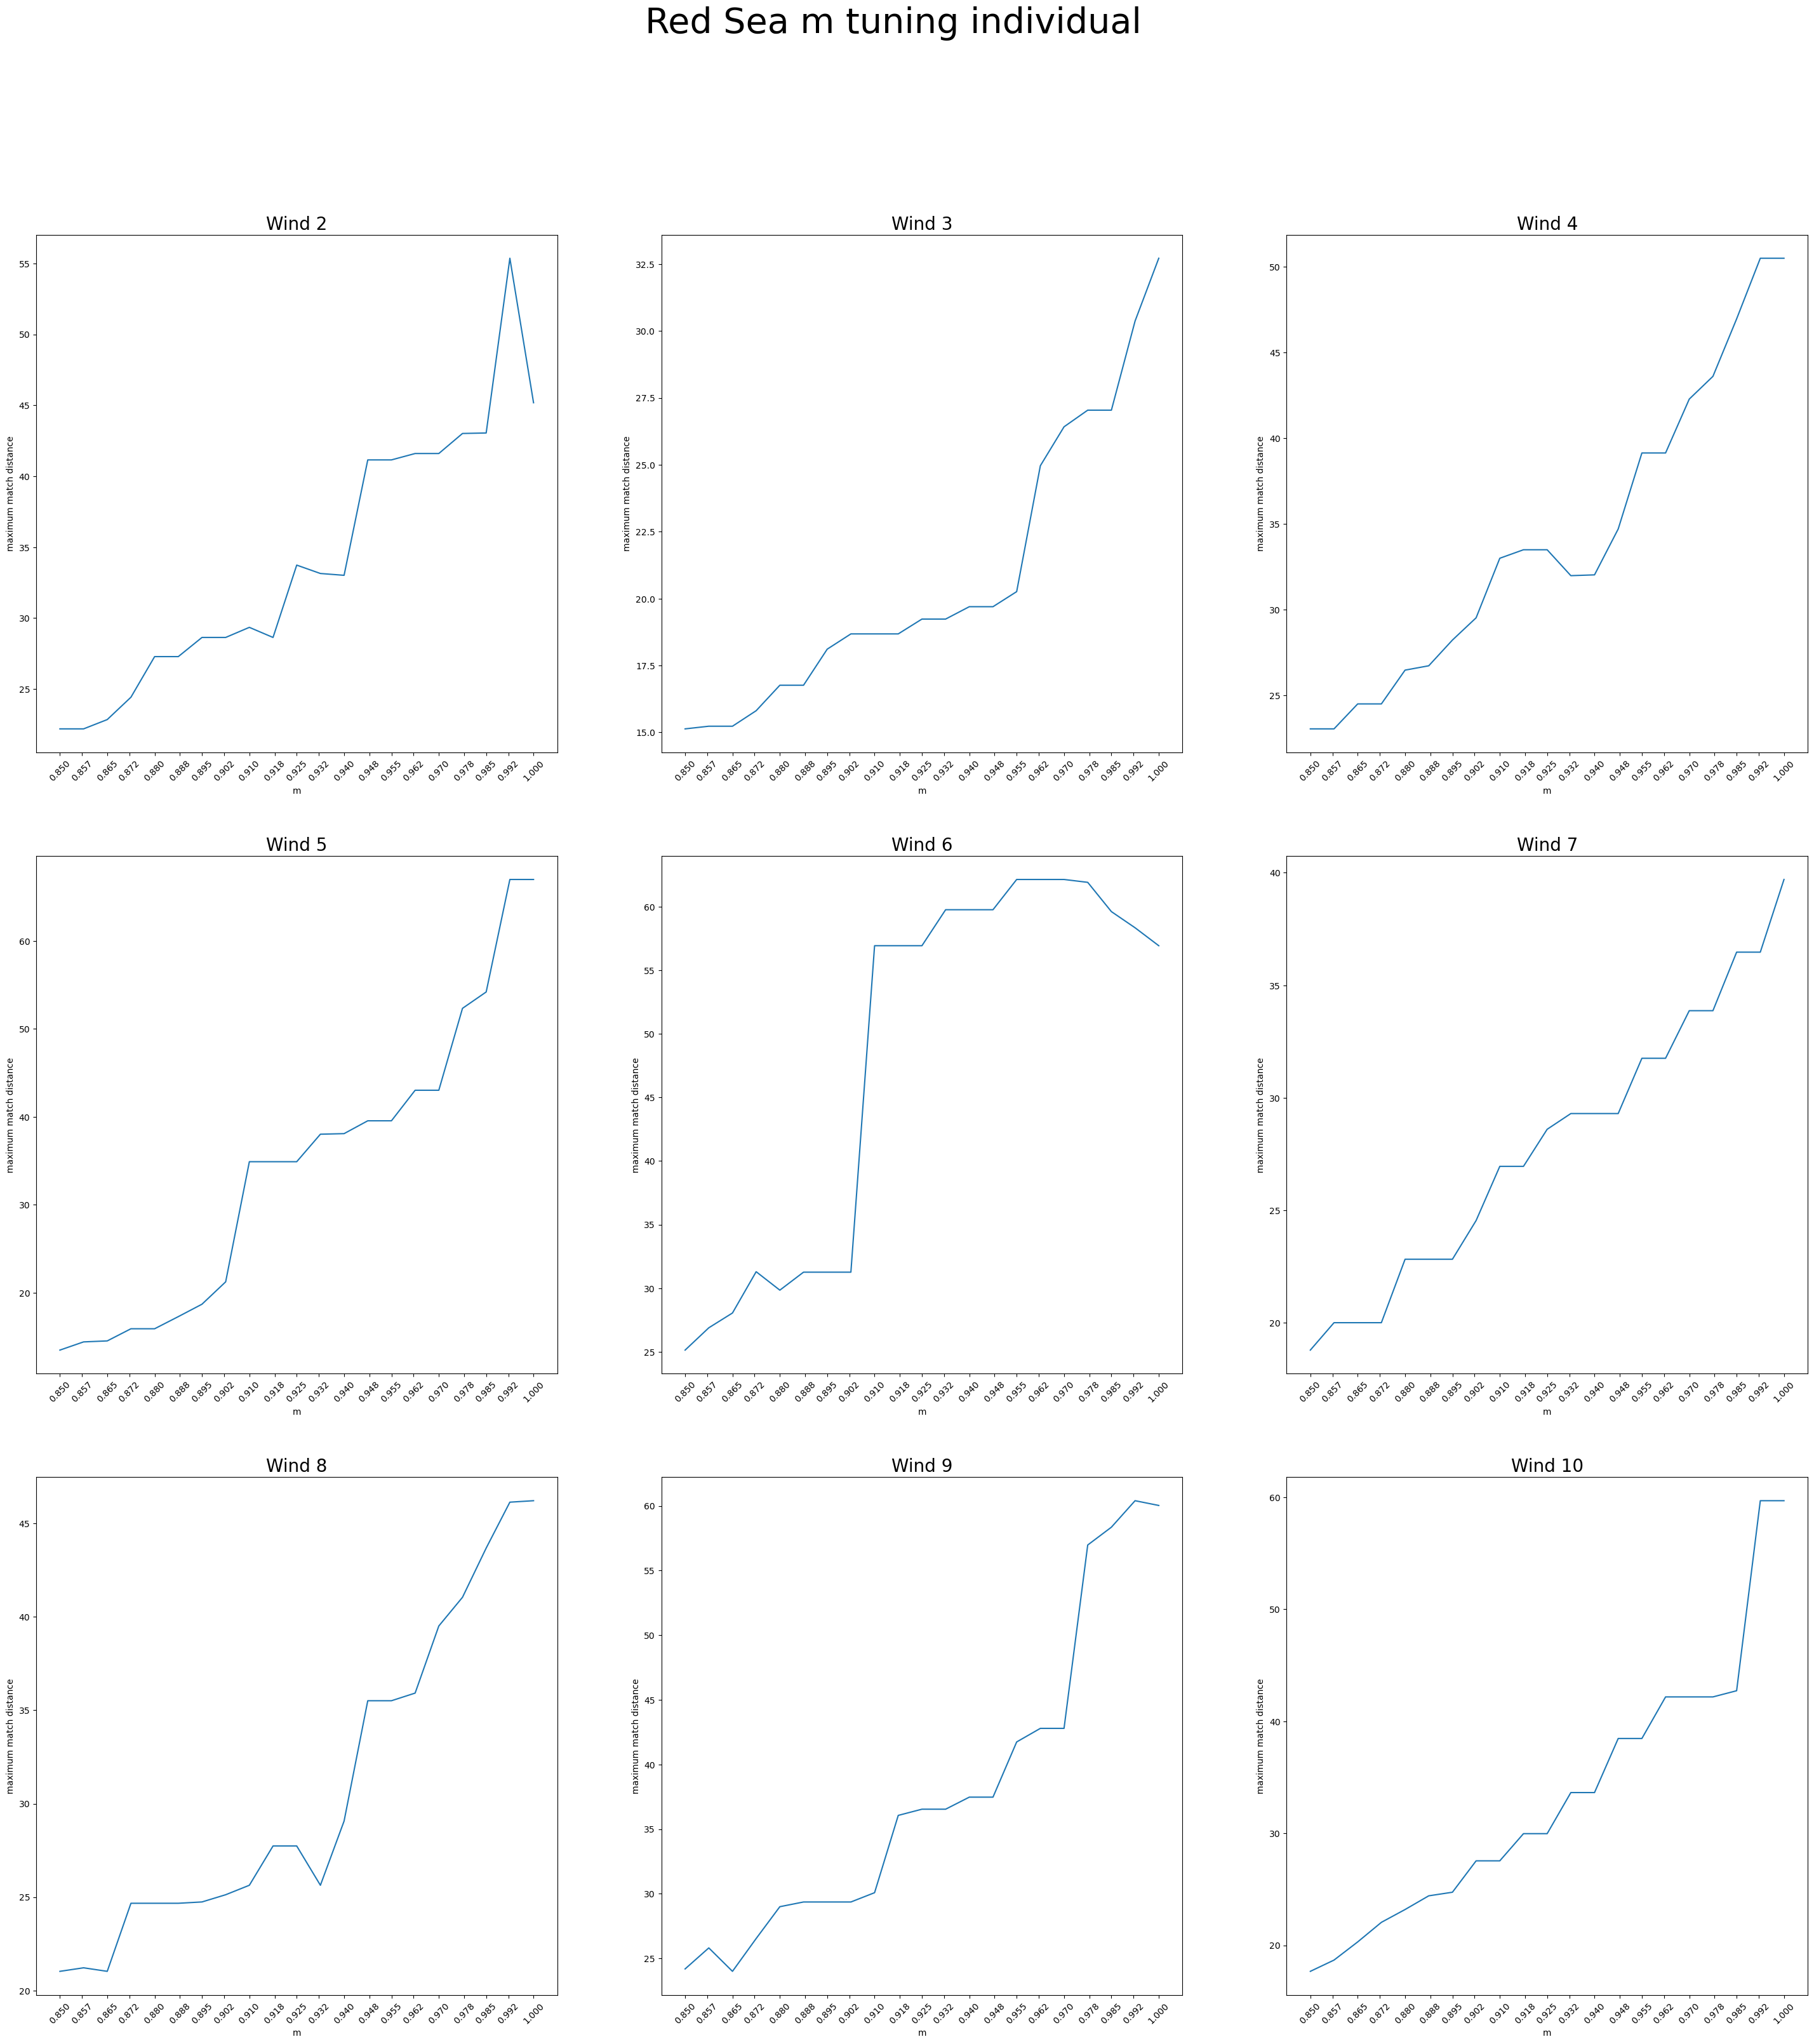

In [25]:
w, h = 3, 3
fig, axes = plt.subplots(h, w, figsize=(w * 12, h * 12))

for res_i, (dest_i, ax) in enumerate(zip(dests.keys(), axes.ravel())):
  x = ms
  y = results[:, res_i]

  ax.plot(x, y)
  ax.set_xticks(np.round(ms, decimals=3))
  ax.tick_params(axis='x', labelrotation=45, labelright=True)

  ax.set_xlabel('m')
  ax.set_ylabel('maximum match distance')

  ax.set_title(f'Wind {dest_i + 1}', fontsize=20)

fig.suptitle('Red Sea m tuning individual', fontsize=40)